In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import statsmodels.tsa.stattools as stattools

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
beer_data = pd.read_excel('2.2 Beer market sales data.xlsx')
tv_data = pd.read_excel('2.3 TV Data.xlsx')

In [3]:
ANALISYS_PARAMETER = 'Daily offtake 0.5l'

In [4]:
beer_data['sum'] = beer_data.loc[:, 'Aug 2014':].sum(axis=1)
beer_data['Brand'][beer_data['Brand'] == 0] = np.nan
beer_data['Brand'].fillna(method='ffill', inplace=True)

/Users/lana/PycharmProjects/world_analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
# рассчитаем сумму по показателю Daily offtake 0.5l
beer_data_daily_offtake = beer_data.loc[beer_data.loc[:,'Metric'] == ANALISYS_PARAMETER]
beer_data_sorted = beer_data_daily_offtake.sort_values(by='sum', ascending=False)


In [6]:
brand_names = []
brand_locators = []
for brand_name in beer_data_sorted['Brand'].values:
    locator = tv_data.loc[:,'BRAND'] == brand_name
    if tv_data.loc[locator].shape[0]:
        brand_locators.append(locator)
        brand_names.append(brand_name)
    # выберем топ-3 брендов, которые рекламировались
    if len(brand_locators) == 3:
        break

In [7]:
locator = brand_locators[0]
for add_locator in brand_locators[1:]:
    locator = locator + add_locator

top3_tv = tv_data.loc[locator]
top3_tv.groupby('BRAND').sum()


/Users/lana/PycharmProjects/world_analysis/venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,DURATION,Clip ID,Clip first issue date,Clip position,Clips count,Break position,Breaks count,TVR M 25-45 BC
BRAND,,,,,,,,
Brand 13,15320,3432111324,51483968,6102,9754,5969,11800,671.05
Brand 26,145230,18817486240,279847921,30777,49620,48117,85198,3275.21
Brand 3,133045,19220140584,288066973,28127,48379,42102,81215,4764.72


In [8]:
def transform_date(date_str):
    date = dateutil.parser.parse(date_str)
    date = date.replace(day=1)
    return date

In [9]:
top3_tv_shortcut = top3_tv.loc[:, ['BRAND', 'MONTH', 'TVR M 25-45 BC']]
top3_tv_shortcut['MONTH'] = top3_tv_shortcut['MONTH'].apply(transform_date)


In [10]:
top3_tv_shortcut = top3_tv_shortcut.groupby(['BRAND', 'MONTH']).sum()
top3_tv_shortcut.reset_index(inplace=True)
top3_tv_shortcut.sort_values(by='MONTH', ascending=True,inplace=True)
top3_tv_shortcut = top3_tv_shortcut.rename(columns={'BRAND':'Brand', 'MONTH':'Month'})


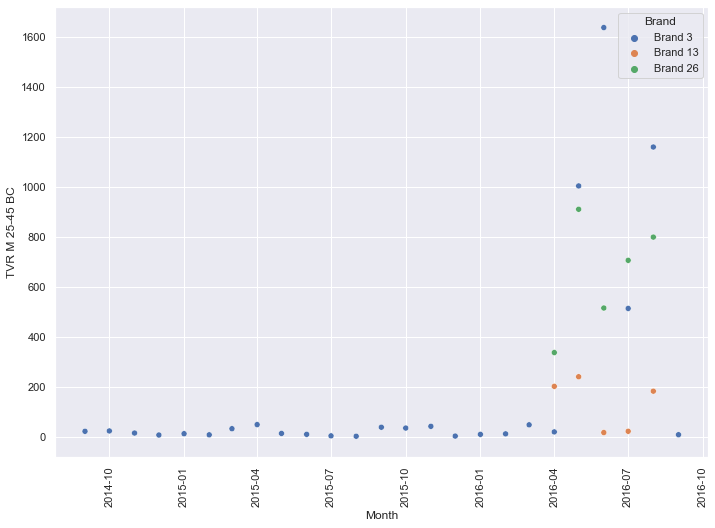

In [11]:
# построим график рекламного воздействия для топ-3 брендов
plot = sns.scatterplot(
    x='Month',
    y='TVR M 25-45 BC',
    hue='Brand',
    data=top3_tv_shortcut,
)

for label in plot.get_xticklabels():
    label.set_rotation(90)

In [12]:
month_dfs = []
for name in brand_names:
    month_column = beer_data_sorted.loc[beer_data_sorted['Brand'] == name].loc[:,'Aug 2014':'Aug 2016'].stack()

    month_column = pd.DataFrame(month_column)
    month_column.reset_index(inplace=True)
    month_column = month_column.rename(columns={0: ANALISYS_PARAMETER, 'level_1': 'Month'})
    month_column['Brand'] = name
    month_column.drop(columns='level_0', inplace=True)
    month_dfs.append(month_column)

monthly_offtake_by_brand = pd.concat(month_dfs)
monthly_offtake_by_brand['Month'] = monthly_offtake_by_brand['Month'].apply(transform_date)
monthly_offtake_by_brand

,Month,Daily offtake 0.5l,Brand
0,2014-08-01,72.610066,Brand 3
1,2014-09-01,59.827639,Brand 3
2,2014-10-01,55.879495,Brand 3
3,2014-11-01,51.262597,Brand 3
4,2014-12-01,55.261698,Brand 3
...,...,...,...
20,2016-04-01,12.451121,Brand 26
21,2016-05-01,13.319161,Brand 26
22,2016-06-01,13.841757,Brand 26
23,2016-07-01,16.440144,Brand 26


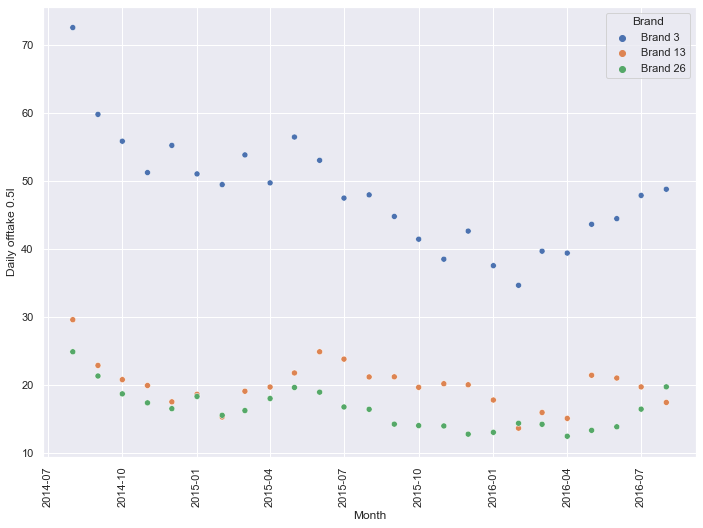

In [13]:
# построим график cредних продаж продукта в расчете на 1 торгующую точку для топ-3 брендов
plot1 = sns.scatterplot(
    x='Month',
    y=ANALISYS_PARAMETER,
    hue='Brand',
    data=monthly_offtake_by_brand
)
for label in plot1.get_xticklabels():
    label.set_rotation(90)

In [14]:
# объединим данные в один датафрейм и разделим по брендам
df = monthly_offtake_by_brand.merge(top3_tv_shortcut, on=['Brand', 'Month'],how='outer')
df.fillna(0,inplace=True)

In [15]:
df_sum = df.groupby('Month').sum()
df_sum

,Daily offtake 0.5l,TVR M 25-45 BC
Month,,
2014-08-01,127.098833,0.00
2014-09-01,104.018157,23.40
2014-10-01,95.351534,24.84
2014-11-01,88.547993,16.50
2014-12-01,89.288610,8.62
2015-01-01,87.988459,13.87
2015-02-01,80.308190,9.38
2015-03-01,89.170039,33.90
2015-04-01,87.446610,50.28


In [16]:
df_brand3 = df.loc[df.loc[:,'Brand'] == 'Brand 3']
df_brand13 = df.loc[df.loc[:,'Brand'] == 'Brand 13']
df_brand26 = df.loc[df.loc[:,'Brand'] == 'Brand 26']
df_brand26

,Month,Daily offtake 0.5l,Brand,TVR M 25-45 BC
50,2014-08-01,24.883790,Brand 26,0.00
51,2014-09-01,21.317416,Brand 26,0.00
52,2014-10-01,18.688800,Brand 26,0.00
53,2014-11-01,17.365495,Brand 26,0.00
54,2014-12-01,16.511580,Brand 26,0.00
55,2015-01-01,18.307672,Brand 26,0.00
56,2015-02-01,15.534033,Brand 26,0.00
57,2015-03-01,16.232039,Brand 26,0.00
58,2015-04-01,18.005279,Brand 26,0.00
59,2015-05-01,19.627475,Brand 26,0.00


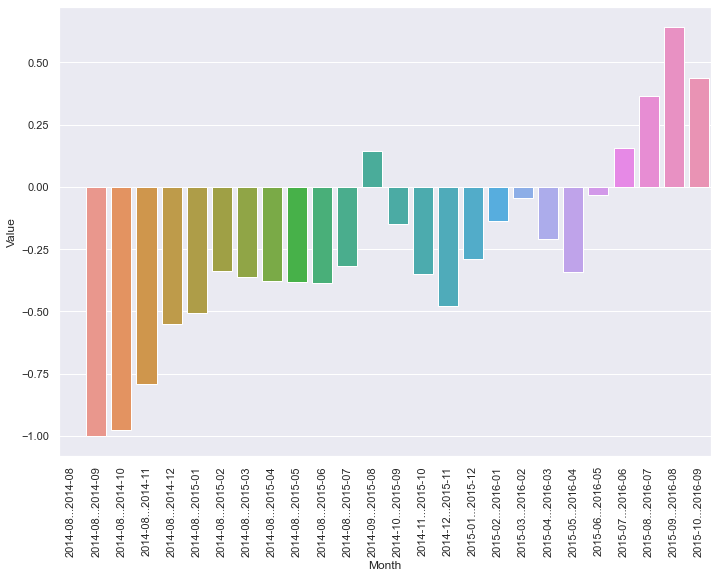

In [17]:
# построим график корреляции в скользящем окне
def get_correlation(df, window=12):
    corr_data = []
    for i, df_r in enumerate(df.rolling(window)):
        # if i < 5: continue
        month_name_a = str(df_r.index.values[0])[:7]
        month_name_b = str(df_r.index.values[-1])[:7]
        corr_value = df_r.corr().values[0][1]
        corr_data.append((f'{month_name_a}...{month_name_b}', corr_value))
    corr_df = pd.DataFrame(corr_data)
    corr_df.rename(columns={0: 'Month', 1: 'Value'}, inplace=True)
    return corr_df

corr_data = get_correlation(df_sum)

plot = sns.barplot(
    x='Month',
    y='Value',
    data=corr_data,
)
for label in plot.get_xticklabels():
    label.set_rotation(90)

In [18]:
# корреляция до начала рекламных компаний
df_sum[:'2016-03-01'].corr()

,Daily offtake 0.5l,TVR M 25-45 BC
Daily offtake 0.5l,1.000000,-0.319403
TVR M 25-45 BC,-0.319403,1.000000


In [19]:
# корреляция после начала рекламных компаний
df_sum['2016-04-01':].corr()

,Daily offtake 0.5l,TVR M 25-45 BC
Daily offtake 0.5l,1.000000,0.796845
TVR M 25-45 BC,0.796845,1.000000


In [20]:
def plot_offtake_to_tvr(df):
    # построение графика зависимости продаж от рекламы
    df = df.sort_values(by='TVR M 25-45 BC', ascending=False)
    df.plot(x='TVR M 25-45 BC', y=ANALISYS_PARAMETER, color='cyan')

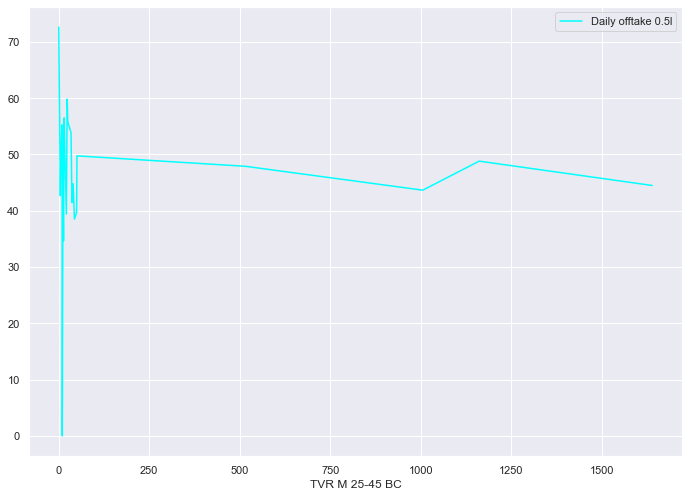

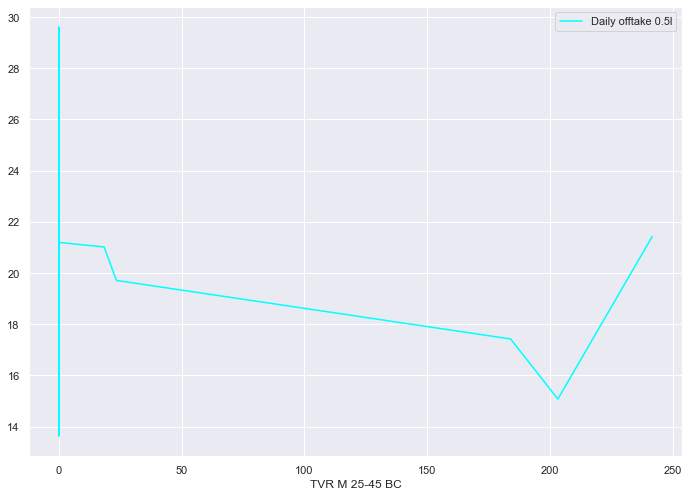

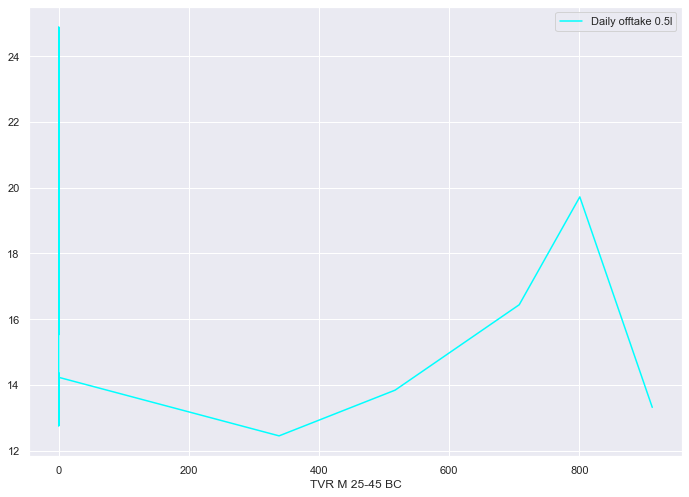

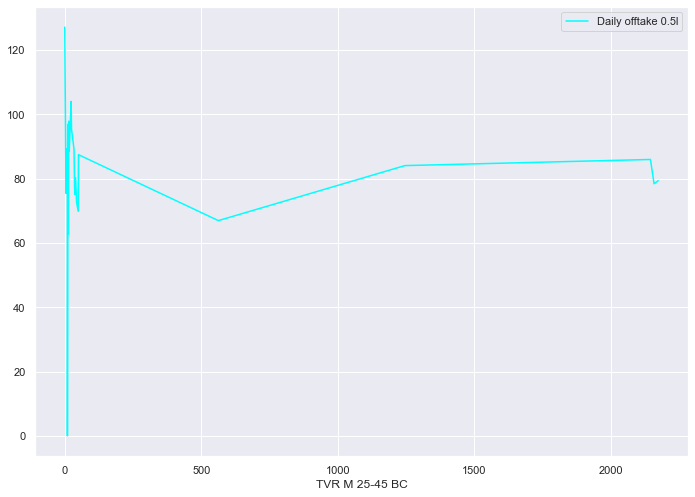

In [21]:
plot_offtake_to_tvr(df_brand3)
plot_offtake_to_tvr(df_brand13)
plot_offtake_to_tvr(df_brand26)
plot_offtake_to_tvr(df_sum)

